<a href="https://colab.research.google.com/github/akivig1601/Website-Phishing-Detection/blob/main/phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Imports and Environment Setup

In [4]:
import subprocess, sys

# Install required packages
for package in ['xgboost', 'optuna', 'shap', 'scikit-learn', 'seaborn', 'matplotlib', 'pandas', 'numpy']:
    try:
        __import__(package)
        print(f"{package}: OK")
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])


xgboost: OK
optuna: OK
shap: OK
seaborn: OK
matplotlib: OK
pandas: OK
numpy: OK


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import optuna
import shap
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

📥 1. Load Dataset

In [6]:
from scipy.io import arff
data, meta = arff.loadarff('Training Dataset.arff')
df = pd.DataFrame(data).applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df = df.apply(pd.to_numeric, errors='coerce').dropna()
print(df.head())

   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  ...  popUpWidnow  Iframe  \

3. EDA and Feature Engineering

EDA

Dataset shape: (11055, 31)
Result
 1    6157
-1    4898
Name: count, dtype: int64


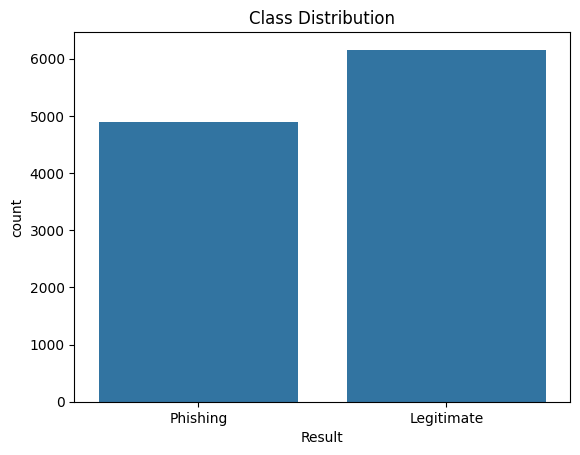

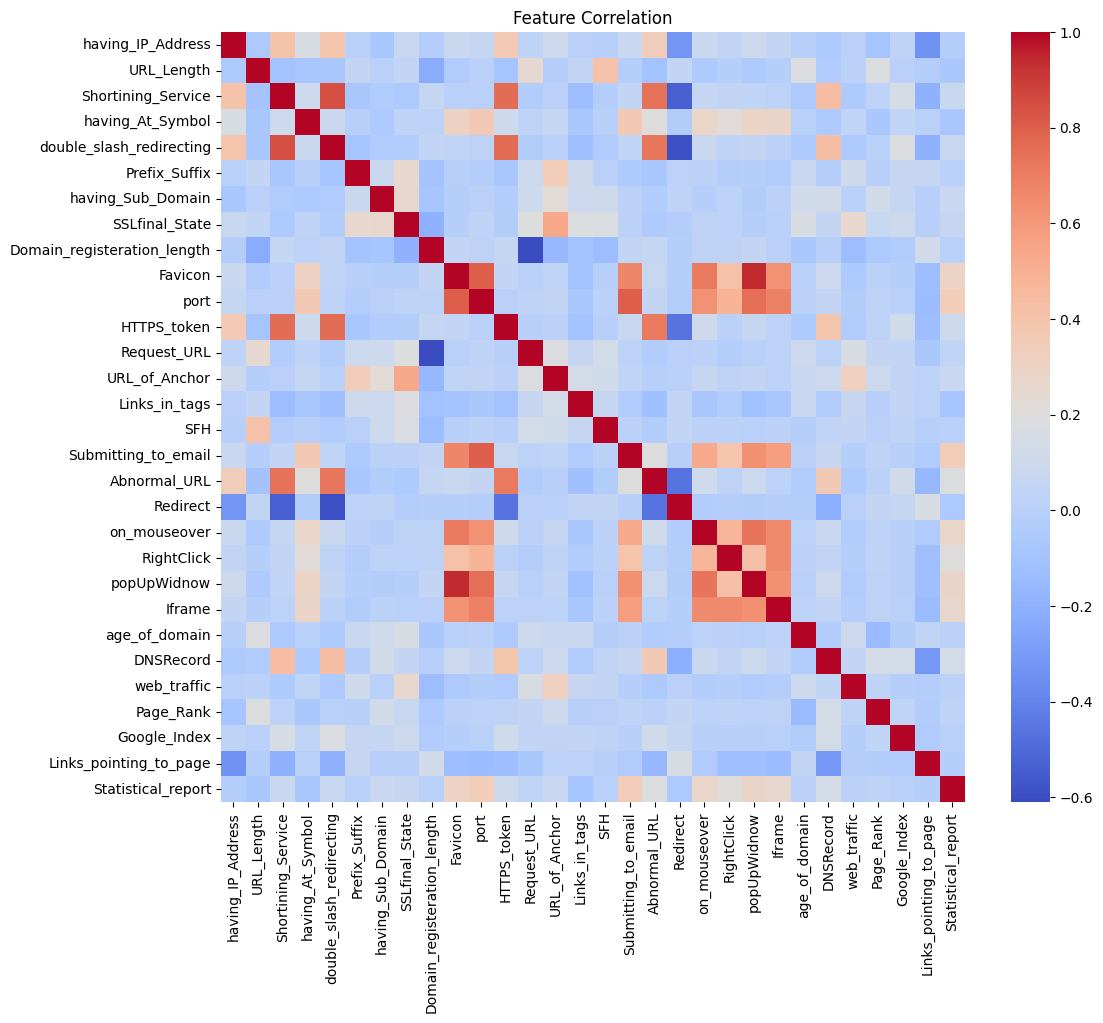

In [7]:
print("Dataset shape:", df.shape)
print(df["Result"].value_counts())
sns.countplot(x=df["Result"].map({-1: 'Phishing', 1: 'Legitimate'}))
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(df.drop('Result', axis=1).corr(), cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

Feature Engineering: N-gram features

Synthesize URL-like strings from features:

In [8]:
def create_url_features(row):
    url_parts = []
    if 'having_Sub_Domain' in row.index and row['having_Sub_Domain'] == 1:
        url_parts.append('subdomain.suspicious')
    if 'URL_Length' in row.index:
        l = row['URL_Length']
        if l > 75:
            url_parts.append('verylongurl')
        elif l > 54:
            url_parts.append('longurl')
    if 'having_At_Symbol' in row.index and row['having_At_Symbol'] == 1:
        url_parts.append('at@symbol')
    if 'double_slash_redirecting' in row.index and row['double_slash_redirecting'] == 1:
        url_parts.append('redirect//')
    return '.'.join(url_parts) if url_parts else 'standard.url.com'

df['synthetic_url'] = df.drop('Result', axis=1).apply(create_url_features, axis=1)


Extract n-gram features:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_ngram_features(urls, ngram_range=(2, 4), max_features=40):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_features, lowercase=True)
    ngram_matrix = vectorizer.fit_transform(urls)
    feature_names = [f'ngram_{name}' for name in vectorizer.get_feature_names_out()]
    return ngram_matrix.toarray(), feature_names

ngram_features, ngram_names = extract_ngram_features(df['synthetic_url'])
ngram_df = pd.DataFrame(ngram_features, columns=ngram_names, index=df.index)


4. Preprocessing

In [10]:
X_original = df.drop(columns=["Result", "synthetic_url"])
X_enhanced = pd.concat([X_original, ngram_df], axis=1)
y = df["Result"]
y_binary = y.map({-1: 0, 1: 1})  # For XGBoost & ML compatibility

X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_binary, stratify=y_binary, test_size=0.2, random_state=RANDOM_STATE
)

5. Model Definitions and Training

In [11]:
models = {
    "Logistic Regression": Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression())
    ]),
    "Decision Tree": Pipeline([
        ('clf', DecisionTreeClassifier())
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
    ]),
    "SVM (RBF)": Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True))
    ]),
    "Gradient Boosting": Pipeline([
        ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

Train and Evaluate

In [12]:
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": classification_report(y_test, y_pred, output_dict=True)[str(1)]["f1-score"] if "1" in classification_report(y_test, y_pred, output_dict=True) else 0,
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

results_df = pd.DataFrame(results).T.sort_values("Accuracy", ascending=False)
print(results_df.round(4))


                     Accuracy      F1  ROC AUC
Random Forest          0.9769  0.9794   0.9978
Decision Tree          0.9701  0.9733   0.9793
Gradient Boosting      0.9530  0.9580   0.9921
SVM (RBF)              0.9408  0.9477   0.9850
Logistic Regression    0.9276  0.9359   0.9808


6. XGBoost With Optuna Hyperparameter Optimization

In [13]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 3),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 3),
        'random_state': RANDOM_STATE,
        'verbosity': 0
    }
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)
optimized_xgb = xgb.XGBClassifier(**study.best_params)
optimized_xgb.fit(X_train, y_train)
models["Optimized XGBoost"] = Pipeline([('clf', optimized_xgb)])

  0%|          | 0/10 [00:00<?, ?it/s]

7. SHAP Explainability

                   feature  importance
13           URL_of_Anchor    2.510166
7           SSLfinal_State    2.317970
5            Prefix_Suffix    0.960159
25             web_traffic    0.828334
14           Links_in_tags    0.675426
6        having_Sub_Domain    0.612568
0        having_IP_Address    0.487636
28  Links_pointing_to_page    0.454997
24               DNSRecord    0.430150
15                     SFH    0.411019


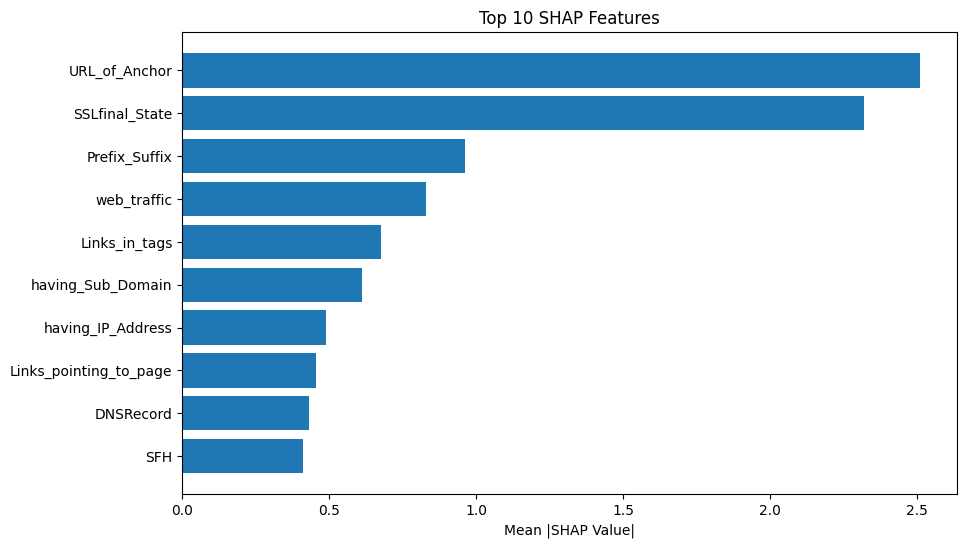

In [14]:
X_test_sample = X_test.iloc[:30].values
feature_names = X_test.columns.tolist()
explainer = shap.TreeExplainer(optimized_xgb)
shap_values = explainer.shap_values(X_test_sample)
feature_importance_shap = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)
print(feature_importance_shap.head(10))
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_shap['feature'][:10], feature_importance_shap['importance'][:10])
plt.xlabel('Mean |SHAP Value|')
plt.title('Top 10 SHAP Features')
plt.gca().invert_yaxis()
plt.show()

8. Stacking Ensemble

In [15]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('lr', Pipeline([('scale', StandardScaler()), ('clf', LogisticRegression())])),
    ('rf', Pipeline([('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))])),
    ('xgb', Pipeline([('clf', optimized_xgb)])),
    ('svm', Pipeline([('scale', StandardScaler()), ('clf', SVC(kernel="rbf", probability=True))]))
]
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
print('Stacking Ensemble Accuracy:', accuracy_score(y_test, y_pred_stack))
models["Stacking Ensemble"] = stacking_clf

Stacking Ensemble Accuracy: 0.9760289461781999


9. Performance Visualization

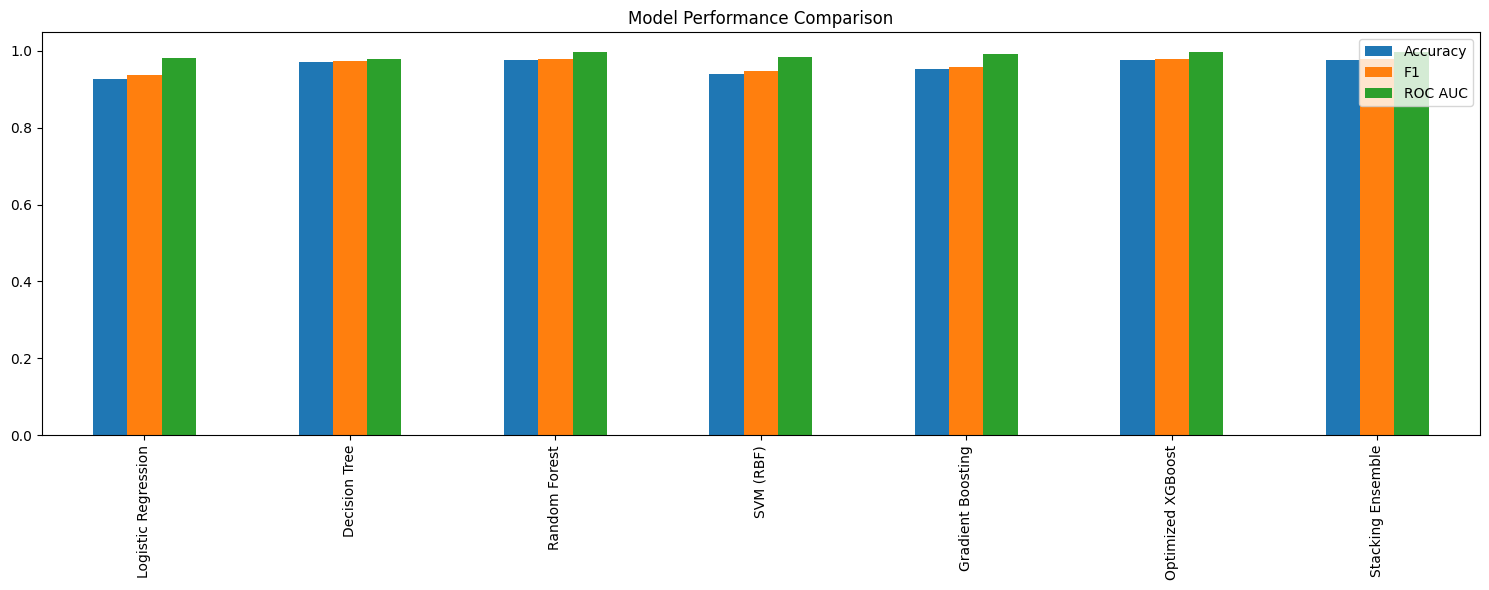

In [16]:
import time
results_enhanced = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    results_enhanced[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": classification_report(y_test, y_pred, output_dict=True)['1']["f1-score"] if "1" in classification_report(y_test, y_pred, output_dict=True) else 0,
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
    }
results_df = pd.DataFrame(results_enhanced).T.round(4)
results_df.plot(kind='bar', figsize=(15,6))
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()